In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_excel('Base de datos v1.xlsx')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID_Cliente               20000 non-null  int64  
 1   Edad                     19700 non-null  float64
 2   Genero                   20000 non-null  object 
 3   Estado_Civil             20000 non-null  object 
 4   Ingreso_Mensual          19500 non-null  float64
 5   Transacciones_Mensuales  20000 non-null  int64  
 6   Monto_Promedio_Compra    19800 non-null  float64
 7   Uso_Linea_Credito_Pct    20000 non-null  float64
 8   Pagos_Atrasados          20000 non-null  int64  
 9   Antiguedad_Meses         20000 non-null  int64  
 10  Productos_Adicionales    20000 non-null  int64  
 11  Fuga                     20000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 1.8+ MB


In [5]:
data.describe()

,ID_Cliente,Edad,Ingreso_Mensual,Transacciones_Mensuales,Monto_Promedio_Compra,Uso_Linea_Credito_Pct,Pagos_Atrasados,Antiguedad_Meses,Productos_Adicionales,Fuga
count,20000.000000,19700.000000,19500.000000,20000.000000,19800.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000
mean,10000.500000,40.187360,4006.623795,31.496050,519.013752,0.285052,0.802350,35.80920,1.088500,0.185350
std,5773.647028,11.628559,2848.305669,31.443938,413.345305,0.159271,0.894217,35.80716,1.204259,0.388591
min,1.000000,18.000000,200.000000,12.000000,23.540000,0.000000,0.000000,1.00000,0.000000,0.000000
25%,5000.750000,32.000000,1916.000000,26.000000,252.875000,0.160000,0.000000,10.00000,0.000000,0.000000
50%,10000.500000,40.000000,3351.000000,30.000000,406.355000,0.260000,1.000000,25.00000,1.000000,0.000000
75%,15000.250000,48.000000,5373.000000,34.000000,647.460000,0.390000,1.000000,50.00000,2.000000,0.000000
max,20000.000000,75.000000,28733.000000,967.000000,6635.400000,0.900000,6.000000,240.00000,8.000000,1.000000


In [6]:
data.isnull().sum()/len(data)*100

ID_Cliente                 0.0
Edad                       1.5
Genero                     0.0
Estado_Civil               0.0
Ingreso_Mensual            2.5
Transacciones_Mensuales    0.0
Monto_Promedio_Compra      1.0
Uso_Linea_Credito_Pct      0.0
Pagos_Atrasados            0.0
Antiguedad_Meses           0.0
Productos_Adicionales      0.0
Fuga                       0.0
dtype: float64

## Imputación nulos

In [7]:
data.dropna(subset=['Edad', 'Ingreso_Mensual', 'Monto_Promedio_Compra'], inplace=True)

In [8]:
data.isnull().sum()/len(data)*100

ID_Cliente                 0.0
Edad                       0.0
Genero                     0.0
Estado_Civil               0.0
Ingreso_Mensual            0.0
Transacciones_Mensuales    0.0
Monto_Promedio_Compra      0.0
Uso_Linea_Credito_Pct      0.0
Pagos_Atrasados            0.0
Antiguedad_Meses           0.0
Productos_Adicionales      0.0
Fuga                       0.0
dtype: float64

## Distribución de variable objetivo

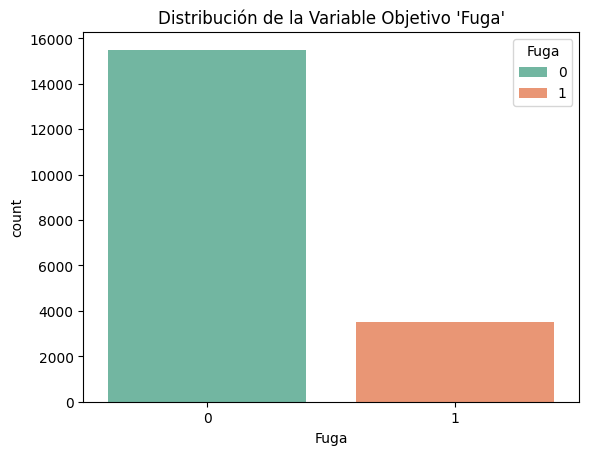

In [9]:
sns.countplot(data=data, x='Fuga', hue='Fuga', palette="Set2")
plt.title("Distribución de la Variable Objetivo 'Fuga'")
plt.show()


Fuga (variable objetivo): El dataset está desbalanceado, lo cual puede requerir técnicas de balanceo para modelos predictivos.


## Pipelines de Cross Validation en la Data cruda usando distintas técnicas de undersampling

In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline as SkPipeline
from imblearn.pipeline import Pipeline 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score, recall_score, precision_score,
    balanced_accuracy_score, matthews_corrcoef, precision_recall_curve, confusion_matrix
)

# Samplers / Ensembles
from imblearn.under_sampling import (
    RandomUnderSampler, NearMiss, InstanceHardnessThreshold, NeighbourhoodCleaningRule
)
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier

# =========================================================
# 0) Datos y división honesta (test imbalanced intacto)
# =========================================================
y = data['Fuga'].astype(int)
X = data.drop(columns=['Fuga'])

num_cols = X.select_dtypes(include=['int64','float64','int32','float32']).columns.tolist()
cat_cols = X.columns.difference(num_cols).tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =========================================================
# 1) Preprocesamiento por tipo de variable
# =========================================================
pre_num = SkPipeline(steps=[
    ('imp', SimpleImputer(strategy='median')),
    ('sc', StandardScaler())
])

# Usa sparse=False para compatibilidad amplia (si tienes sklearn >=1.2 usa sparse_output=False)
pre_cat = SkPipeline(steps=[
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('oh',  OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

pre = ColumnTransformer([
    ('num', pre_num, num_cols),
    ('cat', pre_cat, cat_cols)
])

# =========================================================
# 2) Definir modelos / estrategias a comparar
#    - Baseline con pesos
#    - Undersampling avanzado (NCR, IHT, NearMiss)
#    - Ensembles balanceados (Balanced RF, EasyEnsemble)
# =========================================================
pipelines = {}

# 2.1) Baseline honesto sin remuestrear (pesos balanceados)
pipelines['logit_weighted'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'))
])

# 2.2) Random undersampling (ratio 1:2) + Logit
pipelines['logit_random_under_1to2'] = Pipeline(steps=[
    ('pre', pre),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=42)),  # pos:maj = 1:2
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.3) NCR (limpieza de vecindario) -> RandomUnderSampler + Logit
pipelines['logit_ncr_then_random_under'] = Pipeline(steps=[
    ('pre', pre),
    ('clean', NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.4) IHT (conserva casos difíciles) -> RandomUnder + Logit
pipelines['logit_iht_then_random_under'] = Pipeline(steps=[
    ('pre', pre),
    ('iht', InstanceHardnessThreshold(
        estimator=LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'),
        random_state=42)),
    ('under', RandomUnderSampler(sampling_strategy='auto', random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.5) NearMiss v1 (frontera) + Logit (ojo: sensible a escalado; ya escalamos numéricas)
pipelines['logit_nearmiss_v1'] = Pipeline(steps=[
    ('pre', pre),
    ('nm', NearMiss(version=1)),
    ('clf', LogisticRegression(max_iter=1000, solver='liblinear'))
])

# 2.6) Balanced Random Forest (undersampling interno por árbol)
pipelines['balanced_rf'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', BalancedRandomForestClassifier(
        n_estimators=400, max_depth=None, random_state=42, n_jobs=-1))
])

# 2.7) EasyEnsemble (múltiples subconjuntos balanceados + AdaBoost)
pipelines['easy_ensemble'] = Pipeline(steps=[
    ('pre', pre),
    ('clf', EasyEnsembleClassifier(n_estimators=10, random_state=42, n_jobs=-1))
])

# Opcional: si tienes XGBoost/LightGBM instalados, puedes añadirlos sin remuestreo usando pesos.
# from xgboost import XGBClassifier
# pipelines['xgb_weighted'] = Pipeline(steps=[
#     ('pre', pre),
#     ('clf', XGBClassifier(
#         n_estimators=600, max_depth=4, learning_rate=0.05,
#         subsample=0.9, colsample_bytree=0.9, reg_lambda=1.0,
#         tree_method='hist', eval_metric='aucpr',
#         scale_pos_weight=(y_train.value_counts()[0]/y_train.value_counts()[1]),
#         random_state=42))
# ])

# =========================================================
# 3) Cross-Validation 30 × 10 con métricas relevantes
# =========================================================
cv = RepeatedStratifiedKFold(n_splits=30, n_repeats=10, random_state=42)

scoring = {
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision',  # PR-AUC
    'recall': 'recall',
    'precision': 'precision',
    'f1': 'f1',
    'balanced_accuracy': 'balanced_accuracy',
    'matthews_corrcoef': 'matthews_corrcoef'
}

def evaluar_pipelines(pipelines, X, y, cv, scoring):
    filas = []
    for nombre, pipe in pipelines.items():
        res = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, error_score='raise')
        fila = {'modelo': nombre}
        for m in scoring.keys():
            vals = res['test_' + m]
            fila[m + '_mean'] = vals.mean()
            fila[m + '_std']  = vals.std(ddof=1)
        filas.append(fila)
    resumen = pd.DataFrame(filas).sort_values('average_precision_mean', ascending=False)
    return resumen

cv_summary = evaluar_pipelines(pipelines, X_train, y_train, cv, scoring)

print(cv_summary.to_string(index=False, float_format=lambda x: f"{x:.4f}"))

# =========================================================
# 4) Elegir el mejor por PR-AUC y evaluar en test real
#    Incluye ajuste de umbral por F1 en PR curve
# =========================================================
best_name = cv_summary.iloc[0]['modelo']
best_pipe = pipelines[best_name]
print(f"\nMejor según CV (PR-AUC): {best_name}")

# Reentrenar en TODO el train
best_pipe.fit(X_train, y_train)

# Predicciones en test
if hasattr(best_pipe, "predict_proba"):
    prob_test = best_pipe.predict_proba(X_test)[:, 1]
elif hasattr(best_pipe, "decision_function"):
    # estandarizar a [0,1] vía min-max para PR curve si no hay proba
    df_raw = best_pipe.decision_function(X_test)
    df_min, df_max = df_raw.min(), df_raw.max()
    prob_test = (df_raw - df_min) / (df_max - df_min + 1e-12)
else:
    # fallback a predicción dura (no ideal para PR-AUC)
    prob_test = best_pipe.predict(X_test)

# Métricas continuas
roc = roc_auc_score(y_test, prob_test)
apr = average_precision_score(y_test, prob_test)
print(f"\n[Test] ROC-AUC: {roc:.4f} | PR-AUC: {apr:.4f}")

# Umbral por defecto 0.5
pred_05 = (prob_test >= 0.5).astype(int)
def report(y_true, y_pred, tag):
    print(f"\n[Test] {tag}")
    print(" Confusion matrix:\n", confusion_matrix(y_true, y_pred))
    print(f" Recall: {recall_score(y_true, y_pred):.4f} | Precision: {precision_score(y_true, y_pred):.4f} | "
          f"F1: {f1_score(y_true, y_pred):.4f} | BalAcc: {balanced_accuracy_score(y_true, y_pred):.4f} | "
          f"MCC: {matthews_corrcoef(y_true, y_pred):.4f}")

report(y_test, pred_05, "Umbral 0.5")

# Ajuste de umbral maximizando F1 en PR curve
prec, rec, thr = precision_recall_curve(y_test, prob_test)
f1_vals = 2 * prec * rec / (prec + rec + 1e-12)
# Nota: precision_recall_curve devuelve len(thr) = len(prec) - 1
best_idx = np.nanargmax(f1_vals[:-1])  # excluir el último punto (sin umbral)
best_thr = thr[best_idx]
pred_star = (prob_test >= best_thr).astype(int)

report(y_test, pred_star, f"Umbral óptimo por F1 (t* = {best_thr:.4f})")

# =========================================================
# 5) (Opcional) Umbral por costos de negocio
#    Si costo(FN)=C_FN y costo(FP)=C_FP, umbral ≈ C_FN / (C_FN + C_FP)
# =========================================================
# C_FN, C_FP = 5.0, 1.0
# thr_cost = C_FN / (C_FN + C_FP)
# pred_cost = (prob_test >= thr_cost).astype(int)
# report(y_test, pred_cost, f"Umbral por costos (t*={thr_cost:.3f}, C_FN={C_FN}, C_FP={C_FP})")


/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/kanyewest/Documents/DataMiningTools/data-mining-tools-activities/venv/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


                     modelo  roc_auc_mean  roc_auc_std  average_precision_mean  average_precision_std  recall_mean  recall_std  precision_mean  precision_std  f1_mean  f1_std  balanced_accuracy_mean  balanced_accuracy_std  matthews_corrcoef_mean  matthews_corrcoef_std
              easy_ensemble        0.5813       0.0315                  0.2484                 0.0271       0.4778      0.0488          0.2452         0.0226   0.3238  0.0295                  0.5718                 0.0264                  0.1163                 0.0429
             logit_weighted        0.5572       0.0331                  0.2293                 0.0247       0.6353      0.0529          0.2077         0.0154   0.3129  0.0234                  0.5427                 0.0286                  0.0670                 0.0449
                balanced_rf        0.5573       0.0321                  0.2289                 0.0244       0.2195      0.0426          0.2443         0.0420   0.2307  0.0409                  0

## Grid search en la Data Cruda undersampleada

In [36]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedStratifiedKFold

# Re-define the pipeline without undersampling
pipe_no_undersample = Pipeline(steps=[
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("clf", LogisticRegression(max_iter=1000, solver="liblinear", random_state=42))
])

# Define the parameter grid for GridSearchCV
# We can tune parameters of the imputer, scaler, and classifier
# Example: 'imputer__strategy': ['mean', 'median']
# Example: 'scaler__with_mean': [True, False]
# Example: 'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]
# Example: 'clf__penalty': ['l1', 'l2']
param_grid = {
    'clf__C': [0.01, 0.1, 1, 10],
    'clf__penalty': ['l1', 'l2'],
    'clf__solver': ['liblinear'] # liblinear supports both l1 and l2
}

# Define the cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42) # Use fewer repeats for faster tuning

# Define the undersampling strategy
undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)

# Create the GridSearchCV object
# We will fit the grid search on the data after applying undersampling
grid_search = GridSearchCV(
    estimator=pipe_no_undersample,
    param_grid=param_grid,
    scoring='recall', # Or another appropriate metric for imbalanced data like 'f1', 'roc_auc'
    cv=cv,
    n_jobs=-1,
    verbose=2
)

# Apply undersampling to the entire dataset before grid search
# Note: This is a simplified approach. For a more rigorous evaluation
# where undersampling is done within each CV fold of the GridSearchCV,
# you might need a custom cross-validation loop or a different imblearn pipeline approach.
# However, for hyperparameter tuning, applying it once before can be practical.
X_resampled, y_resampled = undersampler.fit_resample(X, y)


# Fit the grid search model
grid_search.fit(X_resampled, y_resampled)

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score (recall): ", grid_search.best_score_)

# You can access the best model like this:
best_model = grid_search.best_estimator_

best_params = grid_search.best_params_

Fitting 15 folds for each of 8 candidates, totalling 120 fits
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s

[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__sol

## Entrenamiento Data Cruda Undersampleada con los mejores parametros

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Create LogisticRegression with the best parameters from GridSearchCV
model_with_best_params = LogisticRegression(
    C=best_params['clf__C'],
    penalty=best_params['clf__penalty'], 
    solver=best_params['clf__solver'],
    max_iter=1000,
    random_state=42
)

# Fit the model with best parameters
model_with_best_params.fit(X_train, y_train)

# Make predictions
y_pred_best = model_with_best_params.predict(X_test)

# Evaluate the model
print("Model with Best Parameters:")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

Model with Best Parameters:
Accuracy: 0.5293324342548887
              precision    recall  f1-score   support

           0       0.53      0.45      0.49       739
           1       0.53      0.61      0.56       744

    accuracy                           0.53      1483
   macro avg       0.53      0.53      0.53      1483
weighted avg       0.53      0.53      0.53      1483



# EDA data undersampleada

## Análisis Univariado

### Variables cuanti

In [67]:
numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns

In [68]:
numeric_cols = numeric_cols.drop(['ID_Cliente','Fuga'])

In [69]:
from scipy.stats import skew, kurtosis, shapiro

def plot_numeric_distributions(data, numeric_cols):
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        sk = skew(data[col].dropna())
        kt = kurtosis(data[col].dropna())
        _, p = shapiro(data[col].dropna())

        plt.subplot(rows, cols_per_row*2, idx*2-1)
        sns.histplot(data[col], kde=True, bins=20, color="skyblue")
        plt.title(f"{col}\nSkew: {sk:.2f}, Kurt: {kt:.2f}, p={p:.2g}")

        plt.subplot(rows, cols_per_row*2, idx*2)
        sns.boxplot(y=data[col], color="lightcoral", showmeans=True)
        plt.title(f"{col} - Boxplot")

    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7311.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7228.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7414.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7346.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stat

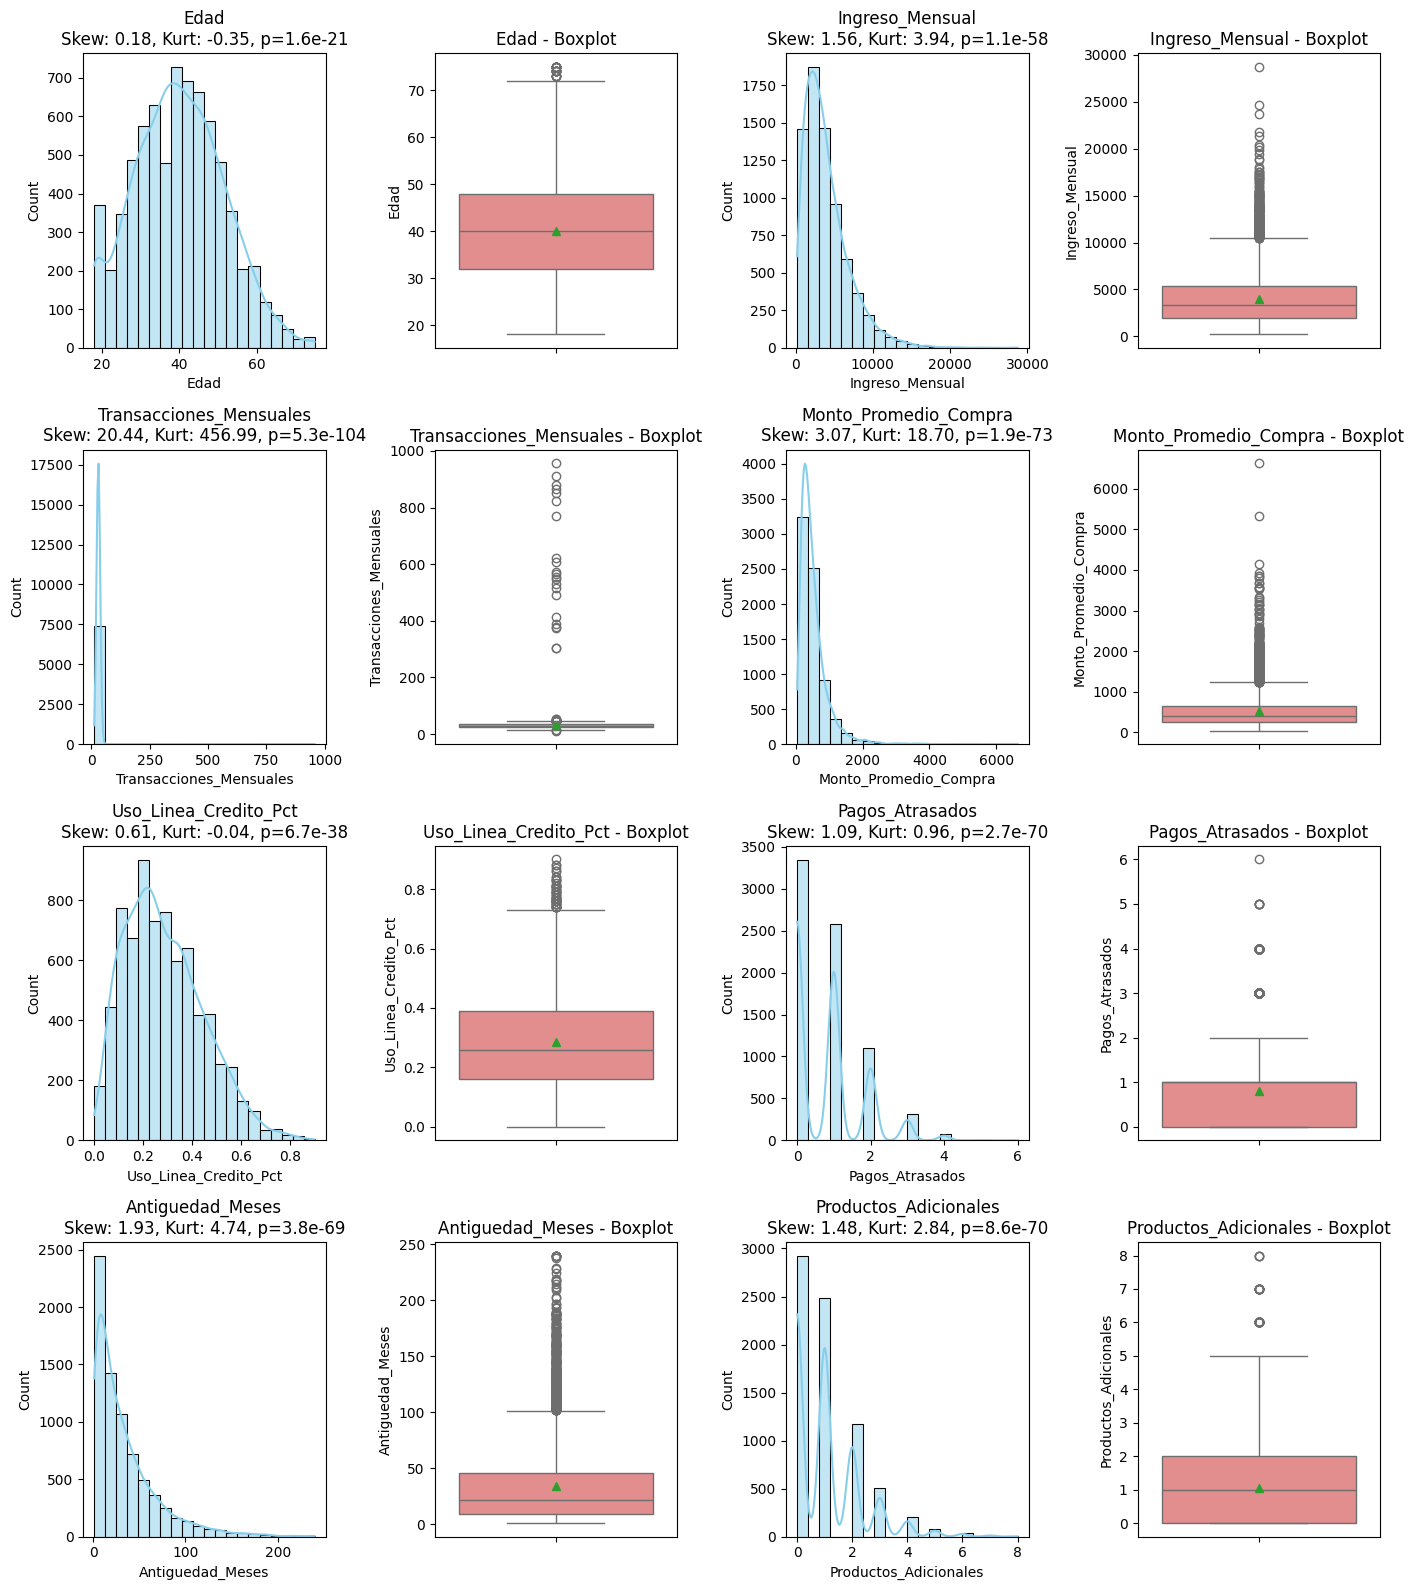

In [70]:
plot_numeric_distributions(data, numeric_cols)

Edad: distribución casi normal, sin valores extremos. La mayoría de clientes está entre 25 y 45 años.

Ingreso mensual: muy asimétrica a la derecha; pocos clientes con ingresos altos y muchos con ingresos bajos o medios.

Transacciones mensuales: extremadamente sesgada; la mayoría realiza pocas transacciones, con algunos casos atípicos muy altos.

Monto promedio de compra: también sesgada positivamente; muchos clientes compran por montos pequeños, pocos con montos muy grandes.

Uso de línea de crédito (%): ligera asimetría a la derecha; la mayoría utiliza menos del 50% de su línea.

Pagos atrasados: la mayoría tiene entre 0 y 1 atraso; pocos clientes con más atrasos (outliers).

Antigüedad (meses): la mayoría de clientes es reciente; pocos con larga antigüedad.

Productos adicionales: distribución discreta; la mayoría tiene 1 o ningún producto adicional.



### Variables cuali

In [71]:
categorical_cols = [col for col in data.select_dtypes(include=['object', 'category']).columns if col != 'Fuga']
categorical_cols.append('Pagos_Atrasados')
categorical_cols.append('Productos_Adicionales')

In [72]:
def plot_categorical_distributions(data, categorical_cols):
    cols_per_row = 3
    n = len(categorical_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 6, rows * 4))

    for idx, col in enumerate(categorical_cols, 1):
        plt.subplot(rows, cols_per_row, idx)
        sns.countplot(data=data, x=col, hue=col, palette="Set2")
        plt.title(f"{col} Distribution")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

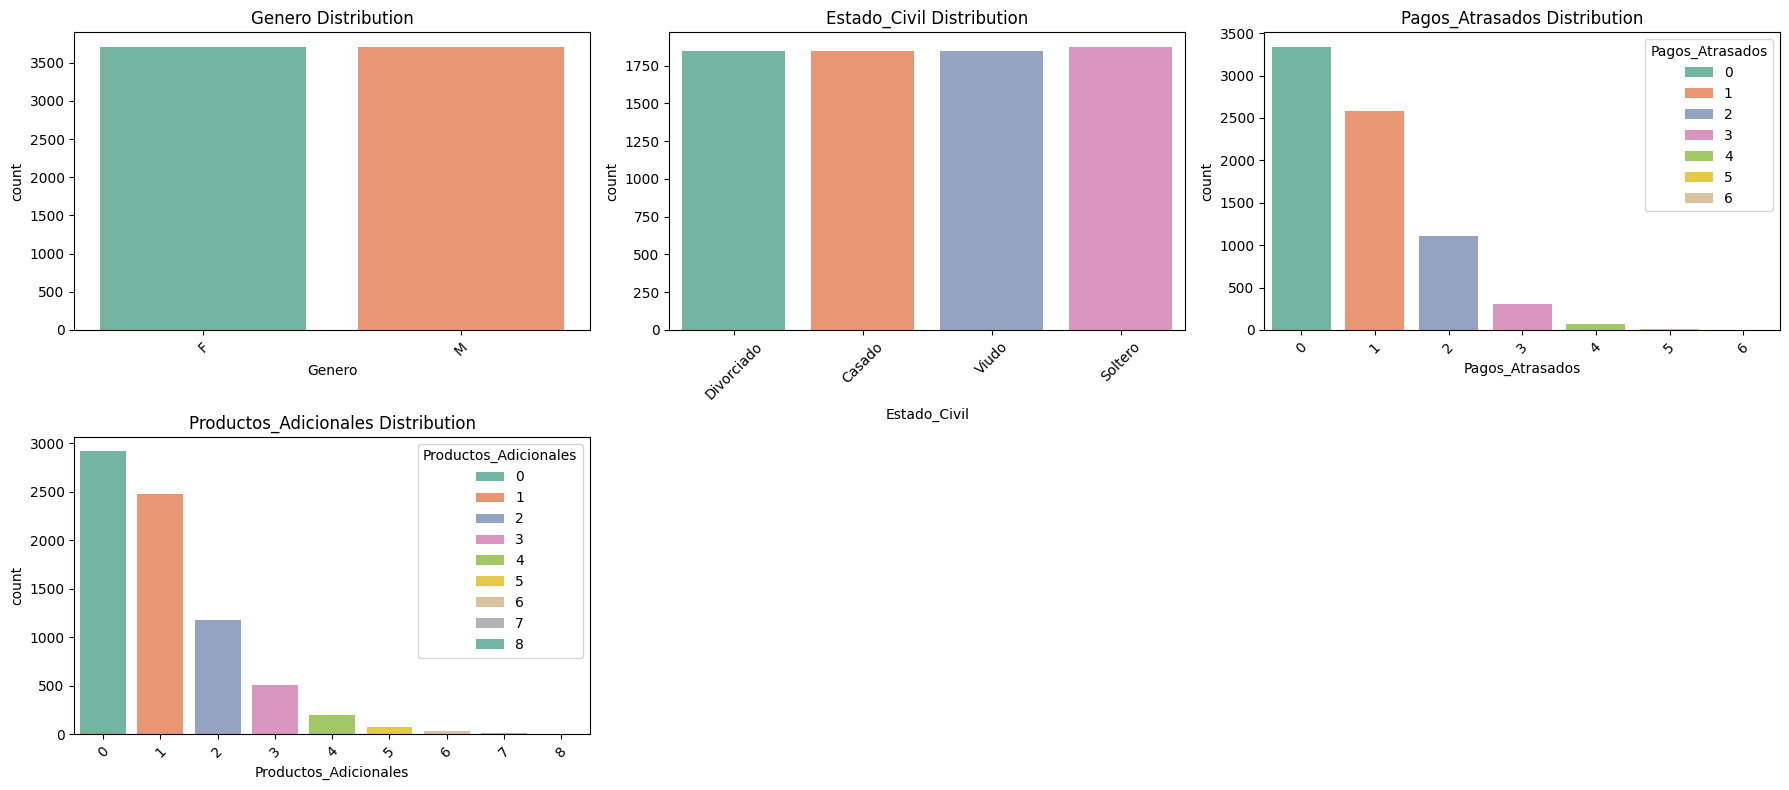

In [73]:
plot_categorical_distributions(data, categorical_cols)

Género: No hay sesgo por género; ambos grupos están representados de forma casi igual.

Estado_civil: No hay una categoría dominante; el estado civil no parece concentrarse en un solo grupo.

Pagos_Atrasados: Indica un buen comportamiento de pago en general; los atrasos múltiples son poco frecuentes.

Productos_Adicionales: Sugiere baja adopción de productos adicionales; posible área de oportunidad comercial.


# Análisis Multivariado

## Multivariado Cuantitativa vs Cuantiativa

In [74]:
numeric_cols = numeric_cols.drop(['Pagos_Atrasados', 'Productos_Adicionales'])

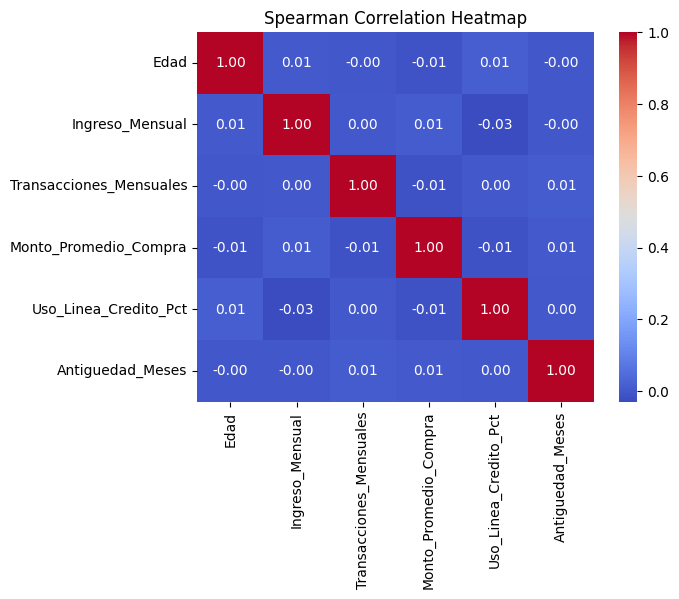

In [75]:
sns.heatmap(data[numeric_cols].corr('spearman'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Spearman Correlation Heatmap")
plt.show()

No existen correlaciones significativas entre las variables numéricas; todos los coeficientes están muy cercanos a 0.

Esto indica que las variables son independientes entre sí, sin relaciones lineales ni monótonas fuertes.

Osea, no hay multicolinealidad en el dataset, lo cual es positivo para hacer un modelado predictivo.

Cada variable podría aportar información distinta en el análisis de la fuga, sin redundancia entre ellas.

In [76]:
from scipy.stats import spearmanr
import numpy as np

def get_spearman_pvalues(df):
    """Calcula matriz de p-valores para correlaciones de Spearman
        args: df (DataFrame): DataFrame con variables numéricas
        return: DataFrame con matriz de p-valores
    """
    cols = df.columns
    n = len(cols)
    p_matrix = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i == j:
                p_matrix[i, j] = 0  # Diagonal siempre 0
            else:
                # Eliminar NaN para el cálculo
                x = df.iloc[:, i].dropna()
                y = df.iloc[:, j].dropna()
                # Encontrar índices comunes (sin NaN en ambas variables)
                common_idx = df[[cols[i], cols[j]]].dropna().index
                if len(common_idx) > 2:
                    corr, p_val = spearmanr(df.loc[common_idx, cols[i]],
                                          df.loc[common_idx, cols[j]])
                    p_matrix[i, j] = p_val
                else:
                    p_matrix[i, j] = np.nan

    return pd.DataFrame(p_matrix, index=cols, columns=cols)

# Calcular matriz de p-valores
p_values_spearman = get_spearman_pvalues(data[numeric_cols])


def correlation_df(df, pval_matrix, method='spearman'):
    # Crear lista de pares únicos (sin repetir)
    corr_matrix = df.corr(method=method)
    pairs_data = []
    cols = df.columns
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            var1, var2 = cols[i], cols[j]
            corr = corr_matrix.loc[var1, var2]
            p_val = pval_matrix.loc[var1, var2]

            # Clasificar fuerza de correlación
            abs_corr = abs(corr)
            if abs_corr < 0.1:
                fuerza = "Muy débil"
            elif abs_corr < 0.3:
                fuerza = "Débil"
            elif abs_corr < 0.5:
                fuerza = "Moderada"
            elif abs_corr < 0.7:
                fuerza = "Fuerte"
            else:
                fuerza = "Muy fuerte"

            pairs_data.append({
                'Par_Variables': f"{var1} ↔ {var2}",
                'Spearman_ρ': corr,
                'p-valor': p_val,
                'Significativo_α05': 'Sí' if p_val < 0.05 else 'No',
                'Fuerza': fuerza
            })

    # Crear DataFrame y ordenar por p-valor
    correlations_df = pd.DataFrame(pairs_data)
    correlations_df = correlations_df.sort_values('p-valor')

    # Redondear valores para mejor legibilidad
    correlations_df['Spearman_ρ'] = correlations_df['Spearman_ρ'].round(4)
    correlations_df['p-valor'] = correlations_df['p-valor'].round(6)

    display(correlations_df)


In [77]:
correlation_df(data[numeric_cols], p_values_spearman, method='spearman')

,Par_Variables,Spearman_ρ,p-valor,Significativo_α05,Fuerza
7,Ingreso_Mensual ↔ Uso_Linea_Credito_Pct,-0.0289,0.013954,Sí,Muy débil
9,Transacciones_Mensuales ↔ Monto_Promedio_Compra,-0.0136,0.243836,No,Muy débil
12,Monto_Promedio_Compra ↔ Uso_Linea_Credito_Pct,-0.0134,0.249928,No,Muy débil
3,Edad ↔ Uso_Linea_Credito_Pct,0.0135,0.250048,No,Muy débil
2,Edad ↔ Monto_Promedio_Compra,-0.0108,0.357678,No,Muy débil
11,Transacciones_Mensuales ↔ Antiguedad_Meses,0.0096,0.409358,No,Muy débil
6,Ingreso_Mensual ↔ Monto_Promedio_Compra,0.0077,0.516622,No,Muy débil
0,Edad ↔ Ingreso_Mensual,0.0060,0.611639,No,Muy débil
13,Monto_Promedio_Compra ↔ Antiguedad_Meses,0.0051,0.662119,No,Muy débil
1,Edad ↔ Transacciones_Mensuales,-0.0045,0.699656,No,Muy débil


No existe multicolinealidad entre variables numéricas, las variables aportan información distinta.

Antigüedad parece ser el principal factor relacionado con el uso de productos adicionales, un posible indicador de fidelidad del cliente.

Las demás correlaciones son insignificantes o muy débiles, por lo que no se espera redundancia en el modelado.

## Multivariado Cualitativa vs Cualitativa

In [78]:
from scipy.stats import chi2_contingency
import numpy as np

def realizar_pruebas_chi2_churn(data, variables_categoricas, target='Fuga', alpha=0.05):
    """
    Realiza pruebas chi-cuadrado para variables categóricas vs Churn.
    Calcula V de Cramer como medida del tamaño del efecto.
    """
    resultados = []

    print("ANÁLISIS CHI-CUADRADO: VARIABLES CATEGÓRICAS vs CHURN")
    print("=" * 65)

    for variable in variables_categoricas:
        if variable == target:  # Skip the target variable itself
            continue

        # Crear tabla de contingencia
        tabla_contingencia = pd.crosstab(data[variable], data[target])

        # Realizar prueba chi-cuadrado
        chi2_stat, p_value, dof, expected = chi2_contingency(tabla_contingencia)

        # Calcular V de Cramer (medida del tamaño del efecto)
        n = tabla_contingencia.sum().sum()
        v_cramer = np.sqrt(chi2_stat / (n * (min(tabla_contingencia.shape) - 1)))

        # Interpretar V de Cramer
        if v_cramer < 0.1:
            efecto = "Muy débil"
        elif v_cramer < 0.3:
            efecto = "Débil"
        elif v_cramer < 0.5:
            efecto = "Moderado"
        else:
            efecto = "Fuerte"

        # Determinar si es significativo
        es_significativo = p_value < alpha

        # Guardar resultados
        resultado = {
            'Variable': variable,
            'Chi2_Estadistico': chi2_stat,
            'p_valor': p_value,
            'Grados_Libertad': dof,
            'V_Cramer': v_cramer,
            'Tamaño_Efecto': efecto,
            'Es_Significativo': 'Sí' if es_significativo else 'No',
            'Interpretacion': 'Rechazar H0 (hay asociación)' if es_significativo else 'No rechazar H0 (no hay asociación)'
        }
        resultados.append(resultado)

        # Mostrar resultados detallados para variables significativas con efecto moderado o fuerte
        if es_significativo and v_cramer >= 0.2:
            print(f"\n Variable: {variable}")
            print(f"   Chi² = {chi2_stat:.4f}")
            print(f"   p-valor = {p_value:.6f}")
            print(f"   V de Cramer = {v_cramer:.4f} ({efecto})")
            print(f"   Resultado: {resultado['Interpretacion']}")
            print(f"   Tabla de Contingencia:")
            # Mostrar tabla con porcentajes
            tabla_pct = pd.crosstab(data[variable], data[target], normalize='index') * 100
            print(tabla_pct.round(1))
            print("-" * 50)

    # Crear DataFrame con todos los resultados
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('V_Cramer', ascending=False)

    return df_resultados

# Realizar las pruebas chi-cuadrado
resultados_chi2 = realizar_pruebas_chi2_churn(data, categorical_cols)

print("\n RESUMEN DE TODAS LAS VARIABLES:")
print("=" * 65)
display(resultados_chi2[['Variable', 'Chi2_Estadistico', 'p_valor', 'V_Cramer',
                        'Tamaño_Efecto', 'Es_Significativo']].round(4))

ANÁLISIS CHI-CUADRADO: VARIABLES CATEGÓRICAS vs CHURN

 RESUMEN DE TODAS LAS VARIABLES:


,Variable,Chi2_Estadistico,p_valor,V_Cramer,Tamaño_Efecto,Es_Significativo
3,Productos_Adicionales,35.9320,0.0000,0.0696,Muy débil,Sí
2,Pagos_Atrasados,33.7227,0.0000,0.0674,Muy débil,Sí
1,Estado_Civil,4.3362,0.2274,0.0242,Muy débil,No
0,Genero,0.1948,0.6590,0.0051,Muy débil,No


Existen asociaciones débiles pero significativas entre fuga y el comportamiento de pagos/productos contratados.

Las variables demográficas no influyen de manera notable en la probabilidad de fuga.

En conjunto, las variables categóricas tienen un bajo/nulo poder explicativo individual, aunque pueden aportar valor combinadas en modelos multivariados.

## Multivariado Cuantitativa vs Cualitativa

In [79]:
def plot_numeric_distributions_by_target(data, target, numeric_cols):
    cols_per_row = 2
    n = len(numeric_cols)
    rows = -(-n // cols_per_row)

    plt.figure(figsize=(cols_per_row * 7, rows * 4))

    for idx, col in enumerate(numeric_cols, 1):
        plt.subplot(rows, cols_per_row*2, idx)
        sns.boxplot(y=data[col], x=data[target], hue=data[target], palette="Set3", showmeans=True)
        plt.title(f"{col} by {target} - Boxplot")

    plt.tight_layout()
    plt.show()

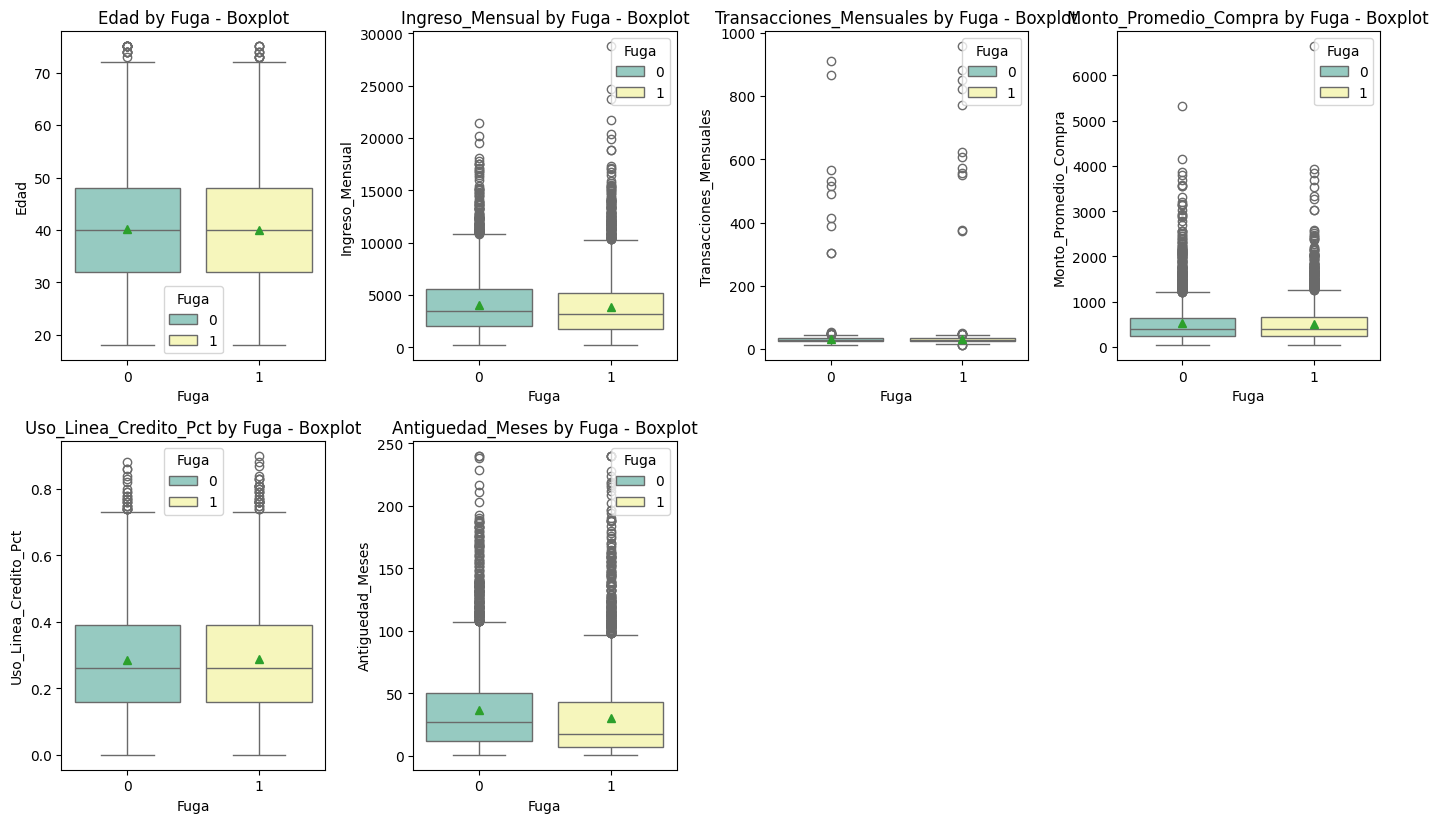

In [80]:
plot_numeric_distributions_by_target(data, 'Fuga', numeric_cols)

Las diferencias entre los grupos son en su mayoría leves, pero destacan menor antigüedad e ingreso en los clientes fugados.

No se aprecian variables numéricas con separación visual fuerte, aunque Antigüedad y Monto Promedio de Compra muestran tendencias útiles para análisis predictivo.

En conjunto, las variables cuantitativas aportan información parcial; su poder explicativo puede mejorar combinándolas con variables categóricas.

In [81]:
from scipy.stats import mannwhitneyu
import numpy as np

def mann_whitney_analysis(data, numeric_cols, target_col, alpha=0.05):
    """
    Performs Mann-Whitney U test for numeric variables vs binary target.
    Calculates effect size using r of Rosenthal.

    Parameters:
    -----------
    data : DataFrame
        The dataset containing numeric and target variables
    numeric_cols : list
        List of numeric column names to test
    target_col : str
        Name of the binary target variable
    alpha : float
        Significance level (default 0.05)

    Returns:
    --------
    DataFrame with test results and effect sizes
    """
    results = []

    # Get unique values of target variable
    target_values = data[target_col].unique()
    if len(target_values) != 2:
        raise ValueError(f"Target variable must be binary. Found {len(target_values)} unique values.")

    group1_label, group2_label = target_values[0], target_values[1]

    for variable in numeric_cols:
        # Separate groups by target variable
        group1 = data[data[target_col] == group1_label][variable].dropna()
        group2 = data[data[target_col] == group2_label][variable].dropna()

        # Check if both groups have data
        if len(group1) == 0 or len(group2) == 0:
            print(f"⚠️  Variable {variable}: No hay datos suficientes")
            continue

        # Perform Mann-Whitney U test
        statistic, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

        # Calculate effect size (r of Rosenthal)
        n1, n2 = len(group1), len(group2)
        n_total = n1 + n2

        # Calculate z-score approximation for effect size
        # For large samples, U approaches normal distribution
        mean_u = n1 * n2 / 2
        std_u = np.sqrt(n1 * n2 * (n1 + n2 + 1) / 12)
        z_score = abs(statistic - mean_u) / std_u

        # r of Rosenthal = z / sqrt(n)
        r_rosenthal = z_score / np.sqrt(n_total)

        # Interpret effect size
        if r_rosenthal < 0.1:
            effect_size = "Muy pequeño"
        elif r_rosenthal < 0.3:
            effect_size = "Pequeño"
        elif r_rosenthal < 0.5:
            effect_size = "Mediano"
        else:
            effect_size = "Grande"

        # Determine significance
        is_significant = p_value < alpha

        # Calculate descriptive statistics
        median_group1 = group1.median()
        median_group2 = group2.median()
        mean_group1 = group1.mean()
        mean_group2 = group2.mean()

        # Store results
        result = {
            'Variable': variable,
            'U_Statistic': statistic,
            'p_value': p_value,
            'r_Rosenthal': r_rosenthal,
            'Effect_Size': effect_size,
            'Significant': 'Sí' if is_significant else 'No',
            f'Median_{group1_label}': median_group1,
            f'Median_{group2_label}': median_group2,
            f'Mean_{group1_label}': mean_group1,
            f'Mean_{group2_label}': mean_group2,
            f'n_{group1_label}': n1,
            f'n_{group2_label}': n2
        }
        results.append(result)

        # Print detailed results
        print(f"Variable: {variable}")
        print(f"   Mann-Whitney U = {statistic:.2f}")
        print(f"   p-valor = {p_value:.6f}")
        print(f"   r de Rosenthal = {r_rosenthal:.4f} ({effect_size})")
        print(f"   Significativo: {'Sí' if is_significant else 'No'}")
        print(f"   Medianas: {group1_label} = {median_group1:.2f}, {group2_label} = {median_group2:.2f}")
        print(f"   Medias: {group1_label} = {mean_group1:.2f}, {group2_label} = {mean_group2:.2f}")
        print(f"   Tamaños de muestra: {group1_label} = {n1}, {group2_label} = {n2}")

        # Interpretation
        if is_significant:
            if median_group2 > median_group1:
                direction = f"{group2_label} tiende a tener valores MÁS ALTOS"
            else:
                direction = f"{group1_label} tiende a tener valores MÁS ALTOS"
            print(f"Interpretación: {direction}")
        else:
            print(f"Interpretación: No hay diferencia significativa entre grupos")

        print("-" * 60)

    # Create results DataFrame
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('r_Rosenthal', ascending=False)

    return results_df

In [82]:
# Execute Mann-Whitney analysis for numeric variables vs Churn
numeric_columns = numeric_cols.tolist()
mann_whitney_results = mann_whitney_analysis(data, numeric_columns, 'Fuga')

print("\nRESUMEN DE RESULTADOS:")
print("=" * 60)
display(mann_whitney_results[['Variable', 'U_Statistic', 'p_value', 'r_Rosenthal',
                             'Effect_Size', 'Significant']].round(4))

Variable: Edad
   Mann-Whitney U = 6776204.50
   p-valor = 0.292770
   r de Rosenthal = 0.0123 (Muy pequeño)
   Significativo: No
   Medianas: 0 = 40.00, 1 = 40.00
   Medias: 0 = 40.24, 1 = 39.95
   Tamaños de muestra: 0 = 3664, 1 = 3647
Interpretación: No hay diferencia significativa entre grupos
------------------------------------------------------------
Variable: Ingreso_Mensual
   Mann-Whitney U = 6876776.00
   p-valor = 0.000095
   r de Rosenthal = 0.0459 (Muy pequeño)
   Significativo: Sí
   Medianas: 0 = 3438.50, 1 = 3209.50
   Medias: 0 = 4098.29, 1 = 3900.30
   Tamaños de muestra: 0 = 3614, 1 = 3614
Interpretación: 0 tiende a tener valores MÁS ALTOS
------------------------------------------------------------
Variable: Transacciones_Mensuales
   Mann-Whitney U = 6859132.50
   p-valor = 0.898024
   r de Rosenthal = 0.0015 (Muy pequeño)
   Significativo: No
   Medianas: 0 = 30.00, 1 = 30.00
   Medias: 0 = 31.38, 1 = 32.10
   Tamaños de muestra: 0 = 3707, 1 = 3707
Interpretación

,Variable,U_Statistic,p_value,r_Rosenthal,Effect_Size,Significant
5,Antiguedad_Meses,7943767.0,0.0000,0.1352,Pequeño,Sí
1,Ingreso_Mensual,6876776.0,0.0001,0.0459,Muy pequeño,Sí
0,Edad,6776204.5,0.2928,0.0123,Muy pequeño,No
3,Monto_Promedio_Compra,6661902.5,0.3580,0.0107,Muy pequeño,No
4,Uso_Linea_Credito_Pct,6844929.5,0.7778,0.0033,Muy pequeño,No
2,Transacciones_Mensuales,6859132.5,0.8980,0.0015,Muy pequeño,No


Las variables Antigüedad_Meses y Ingreso_Mensual muestran diferencias estadísticamente significativas entre clientes que se fugan y los que permanecen (p < 0.05).

Aunque las diferencias son muy pequeñas en magnitud (r < 0.1), sugieren que los clientes más nuevos y de menor ingreso son más propensos a fugarse.

Las demás variables (Edad, Monto_Promedio_Compra, Uso_Linea_Credito_Pct, Transacciones_Mensuales) no presentan diferencias significativas entre ambos grupos, lo que indica que no influyen directamente en la fuga.

# Feature Engineering

# Entrenamiento data preparada

# Resultados